In [ ]:
# %%bash
# git clone https://github.com/lessw2020/Ranger21.git
# cd Ranger21
# pip install -e .

In [ ]:
# %cd Ranger21
# %pip install -e .

In [ ]:
# %cd ..

In [ ]:
%%bash
git clone https://github.com/AntixK/PyTorch-VAE
cd PyTorch-VAE
pip install -r requirements.txt -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.4/525.4 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 51.7 MB/s eta 0:00:00


Cloning into 'PyTorch-VAE'...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


In [ ]:
%cd PyTorch-VAE

/content/PyTorch-VAE


In [ ]:
!pip install lmdb -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 3.3 MB/s eta 0:00:00


In [ ]:
!mkdir data

In [ ]:
from models.cvae import ConditionalVAE
from models.beta_vae import BetaVAE
from models.vq_vae import VQVAE
# from ranger21 import Ranger21

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
# import torch_xla.core.xla_model as xm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# device = xm.xla_device()
# Define transformations
transform = transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR10 dataset
trainset = torchvision.datasets.CelebA(root='/content/drive/MyDrive/celebAgreyscale', split = "train",
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=300,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CelebA(root='/content/drive/MyDrive/celebAgreyscale', split = "test",
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=0)

1443490838it [00:18, 77738073.49it/s] 
26721026it [00:00, 79934117.85it/s]
3424458it [00:00, 192247803.39it/s]
6082035it [00:00, 141554181.60it/s]
12156055it [00:00, 193041030.86it/s]
2836386it [00:00, 37716782.16it/s]


Files already downloaded and verified


In [ ]:
X, y = next(iter(trainloader))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
X.size()

torch.Size([300, 3, 64, 64])

In [ ]:
torch.cuda.empty_cache()
latent_dim = 500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vae = VQVAE(in_channels = 3, embedding_dim = 32, num_embeddings = 512, latent_dim = 128, num_classes = 2, beta = 0.25).to(device)
num_epochs = 100

optimizer = torch.optim.AdamW(vae.parameters(), lr=0.0005)
vae.train()
k = 0
for epoch in range(1, num_epochs + 1):

    train_recon_loss = 0
    train_kl_loss = 0

    for (data, labels) in trainloader:
        color, labels = data.to(device), labels.to(device)
        grayscale = torchvision.transforms.Grayscale(num_output_channels=3)(color).to(device)

        color_labels = torch.zeros(color.size()[0], dtype = torch.int).to(device)
        grayscale_labels = torch.zeros(grayscale.size()[0], dtype = int).to(device)

        optimizer.zero_grad()

        data = torch.cat([color, grayscale])
        # data = color

        recon_data, original, vq_loss = vae(data, labels = torch.cat([color_labels, grayscale_labels]))

        losses = vae.loss_function(recon_data, original, vq_loss)

        recon_loss = losses['Reconstruction_Loss']
        total_loss = losses['loss']

        total_loss.backward()
        optimizer.step()

        k += 1
        print((recon_loss.item(), total_loss.item()))
        train_recon_loss += recon_loss.item()

(0.3774693012237549, 0.37860652804374695)
(0.3703666925430298, 0.3725373148918152)
(0.34578925371170044, 0.3506924510002136)
(0.34598636627197266, 0.3700292408466339)
(0.3453446328639984, 0.5284633636474609)
(0.35250312089920044, 1.6717369556427002)
(0.35969069600105286, 2.611176013946533)
(0.3407319188117981, 1.5727481842041016)
(0.3463478088378906, 4.804669380187988)
(0.3277433216571808, 19.494827270507812)
(0.3280346095561981, 71.36341857910156)
(0.34711065888404846, 22.956010818481445)
(0.331864595413208, 15.831180572509766)
(0.3407904803752899, 11.260252952575684)
(0.3504084050655365, 13.320402145385742)
(0.3358175754547119, 23.420141220092773)
(0.3360973298549652, 18.568706512451172)
(0.3233044445514679, 25.50617218017578)
(0.31751152873039246, 60.93589782714844)
(0.30076873302459717, 40.65321350097656)
(0.2931961715221405, 112.14491271972656)
(0.26726600527763367, 247.64979553222656)
(0.2620755434036255, 1885.3614501953125)
(0.2544616758823395, 835.6349487304688)
(0.229150056838

KeyboardInterrupt: ignored

In [ ]:
torch.save(vae.state_dict(), '/content/drive/MyDrive/celebAgreyscale/vae_32_16_16.pt')

In [ ]:
# # prompt: reconstruct and visualize X with the vae with torchvision

# with torch.no_grad():
#         vae.eval()
#         for (data, labels) in testloader:
#             data = data.to(device)
#             recon = vae(data)
#             for i in range(0, recon.size()[0]):
#                 original = data[i]
#                 reconstructed = recon[i]
#                 img = torch.cat([original, reconstructed], dim = 0)
#                 img = torchvision.utils.make_grid(img, nrow = 2)
#                 writer.add_image('recon_img', img, global_step = k)
#                 k += 1

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
sX = torchvision.transforms.Grayscale(num_output_channels=3)(X[0:8, :, :, :])
# sX = (X[0:8, :, :, :])

In [ ]:
cpu_vae = vae.to('cpu')
cpu_vae.eval()
recon_data, original, vq_loss = cpu_vae(sX)

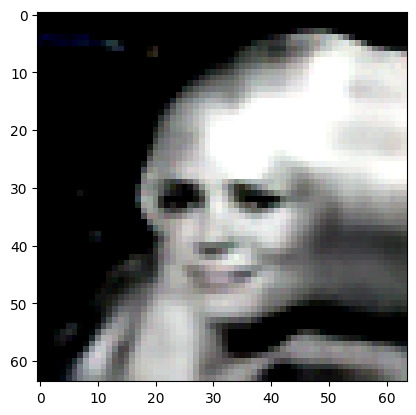

In [ ]:
plt.imshow((recon_data[3] + .5).permute(1, 2, 0).detach())

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# torch.save(vae.state_dict(), '/content/drive/MyDrive/celebAgreyscale/vae.pt')